 # 顧客留言STP分群分析



 針對PTT運動內衣留言進行顧客分群，以了解不同客群的需求和關注點。

In [1]:
# 載入套件
import pandas as pd


 ## 資料匯入與前處理

In [2]:
# 讀入留言資料
underweardata = pd.read_csv('data/PTT_運動內衣_onepage資料留言內容.csv')


 ## 特徵擷取與資料準備



 決定使用關鍵字作為分群特徵

In [3]:
# 決定分群的特徵值: 載入自選關鍵字
feature = ["跑步", "健身", "瑜珈", "舒適", "好看", "彈性"]

# 產出每一個Tag欄位，計算每一個商品被該Tag提到與否
for i in feature:
    underweardata[i] = underweardata['content'].apply(lambda x: 1 if i in x else 0)  # 如果留言內容含feature字詞，就計數１

# 根據每個使用者做彙總
underweardata["聲量"] = 1

feature.append("聲量")  # 將聲量欄位名加入特徵值list，以利後續讀取資料使用

underweardata_cluster = underweardata.groupby(['user'], as_index=False)[feature].sum()


 ## 練習：聲量分析



 請問誰是聲量大師, 請找出前10名聲量最高的人

In [4]:
# 找出聲量前10名的使用者
top_contributors = underweardata_cluster.sort_values(by='聲量', ascending=False).head(10)
print("聲量大師 - 前10名聲量最高的使用者：")

top_contributors[['user', '聲量']]


聲量大師 - 前10名聲量最高的使用者：


,user,聲量
25,ie975249,8
36,love91041,4
37,mavis825,4
55,sunnny,4
47,riesz0505,3
52,sodahaini,3
50,sleepdesign,3
23,hjkl369,3
6,Valentine17,3
59,wenyu66,3


 ## 使用機器學習自動決定分群數量

In [5]:
# 將'user','聲量'設定爲index，這樣做分群的時候就不會被當特徵值
underweardata_cluster = underweardata_cluster.set_index(['user', '聲量'])


 ### 方法一：Elbow方法，找轉折點

In [6]:
from sklearn.cluster import KMeans

distortions = []
for k in range(1, 15):
    kmeanModel = KMeans(n_clusters=k, random_state=1).fit(underweardata_cluster)
    distortions.append(kmeanModel.inertia_)  # Inertia計算群內所有點到該群的中心的距離的總和。


/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/p

In [7]:
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

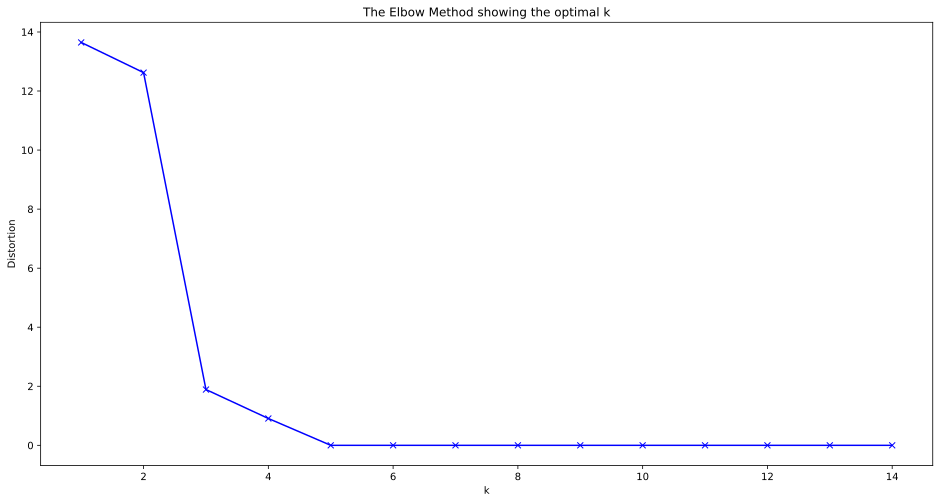

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(range(1, 15), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


 ### 方法二：silhouette_score，越大越好

In [9]:
from sklearn.metrics import silhouette_score

for k in range(2, 15):
    kmeanModel = KMeans(n_clusters=k, random_state=1).fit(underweardata_cluster)
    silhouette_avg = silhouette_score(underweardata_cluster, kmeanModel.labels_)

    print('Silhouette Score for %i Clusters: %0.4f' % (k, silhouette_avg))


Silhouette Score for 2 Clusters: 0.6892
Silhouette Score for 3 Clusters: 0.9323
Silhouette Score for 4 Clusters: 0.9435
Silhouette Score for 5 Clusters: 0.9516
Silhouette Score for 6 Clusters: 0.9516
Silhouette Score for 7 Clusters: 0.9516
Silhouette Score for 8 Clusters: 0.9516
Silhouette Score for 9 Clusters: 0.9516
Silhouette Score for 10 Clusters: 0.9516
Silhouette Score for 11 Clusters: 0.9516
Silhouette Score for 12 Clusters: 0.9516
Silhouette Score for 13 Clusters: 0.9516
Silhouette Score for 14 Clusters: 0.9516


/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Volumes/Dev/nkust/nkust-homework/semester-6/marketing/06-comment-stp-sku/.venv/lib/p

 ## 執行分群

In [10]:
# 最後決定分5群
clustering = KMeans(n_clusters=5, random_state=1).fit(underweardata_cluster)

# 查看分群標籤
clustering.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 4, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [11]:
# 查看各群中心值
clustering.cluster_centers_


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38777878e-17,
        1.11022302e-16, 1.38777878e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.46944695e-18,
        1.00000000e+00, 3.46944695e-18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 0.00000000e+00]])

In [12]:
# 將群放入underweardata_cluster
underweardata_cluster['群'] = clustering.labels_

# 將之前的user', '聲量'解放回來
underweardata_cluster = underweardata_cluster.reset_index()

# 設定過渡參數【人數】，後續用來統計每一群的市場人數
underweardata_cluster['人數'] = 1

# 找出每一個群體的特徵加總個數
underweardata_cluster_group = underweardata_cluster.groupby(['群'], as_index=False).sum()
underweardata_cluster_group.drop('user', axis=1, inplace=True)

underweardata_cluster_group

,群,聲量,跑步,健身,瑜珈,舒適,好看,彈性,人數
0,0,8,0,0,0,0,0,1,1
1,1,83,0,0,0,0,0,0,49
2,2,13,0,0,0,0,10,0,10
3,3,3,0,0,0,1,0,0,1
4,4,3,0,0,0,0,2,0,1


 ## 練習：各群體關鍵詞視覺化



 請將underweardata_cluster_group為underweardata_cluster_groupnew，X軸為群類別，Y為各關鍵詞的聲量，繪製折線圖，如此以看出各群關鍵詞的消長

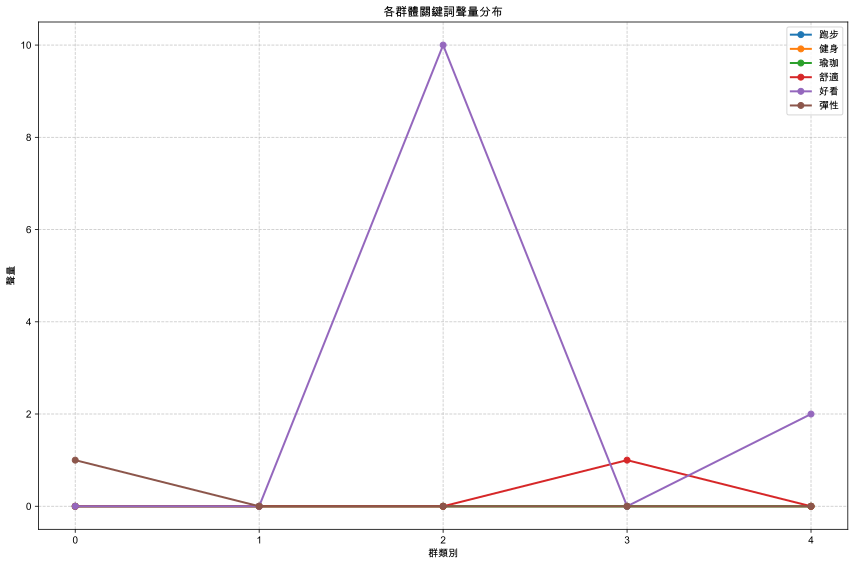

In [13]:
underweardata_cluster_groupnew = underweardata_cluster_group.copy()

# 設定中文字型避免亂碼
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定圖表大小
plt.figure(figsize=(12, 8))

# 準備關鍵詞列表（不包括非關鍵詞的欄位）
keywords = [feat for feat in feature if feat != "聲量"]

# 為每個關鍵詞繪製折線
for keyword in keywords:
    plt.plot(underweardata_cluster_groupnew['群'], 
             underweardata_cluster_groupnew[keyword], 
             marker='o', 
             linewidth=2, 
             label=keyword)

# 添加標題與標籤
plt.title('各群體關鍵詞聲量分布')
plt.xlabel('群類別')
plt.ylabel('聲量')
plt.xticks(underweardata_cluster_groupnew['群'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

# 顯示圖表
plt.tight_layout()
plt.show()


 ## 練習：群體人數與聲量對比



 請將underweardata_cluster_group為underweardata_cluster_groupnew1，畫出各群人數(長條圖)與聲量(折線圖)。左側Y軸為人數刻度，右側Y軸為聲量刻度

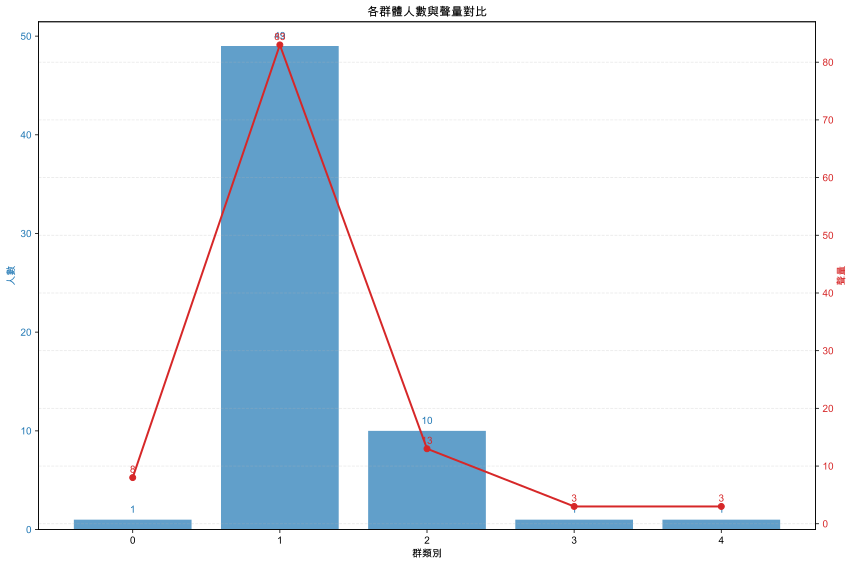

In [14]:
underweardata_cluster_groupnew1 = underweardata_cluster_group.copy()

# 設定中文字型避免亂碼
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 創建圖表和第一個Y軸
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title('各群體人數與聲量對比')
plt.xlabel('群類別')

# 繪製長條圖 - 人數 (ax1)
bars = ax1.bar(underweardata_cluster_groupnew1['群'], underweardata_cluster_groupnew1['人數'], 
         color='tab:blue', alpha=0.7)
ax1.set_ylabel('人數', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 在長條圖上添加數值標籤
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}',
            ha='center', va='bottom', color='tab:blue', fontweight='bold')

# 創建第二個Y軸
ax2 = ax1.twinx()

# 繪製折線圖 - 聲量 (ax2)
line = ax2.plot(underweardata_cluster_groupnew1['群'], underweardata_cluster_groupnew1['聲量'], 
         color='tab:red', marker='o', linewidth=2, label='聲量')
ax2.set_ylabel('聲量', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 在折線圖上添加數值標籤
for i, value in enumerate(underweardata_cluster_groupnew1['聲量']):
    ax2.text(i, value + 0.5, f'{int(value)}', 
             ha='center', va='bottom', color='tab:red', fontweight='bold')

# 添加網格線和調整布局
plt.grid(True, linestyle='--', alpha=0.3)
fig.tight_layout()
plt.show()